In [1]:
# importing libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate

In [2]:
#Reading the data 
columns = ['SAM', 'nino', 'ISMR', 'AMO', 'NAO', 'PDO', 'At-nino', 'IOD']
# read text file into pandas DataFrame
df = pd.read_csv("S_n_I_A_N_P_An_Io_noaa2.txt", sep="\s{2,}", names = columns, engine='python')
df = df.drop(['SAM'], axis = 1)
# normalizing the data
cols_to_norm = ['nino', 'AMO', 'NAO', 'PDO', 'At-nino', 'IOD']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
print(df.head())

       nino      ISMR       AMO       NAO       PDO   At-nino       IOD
0  0.436163  10.24380  0.673493  0.591201  0.715718  0.645570  0.246303
1  0.445793  44.16110  0.737709  0.535254  0.261536  0.810627  0.313120
2  0.472214   4.76807  0.740996  0.665336  0.542929  0.704167  0.157643
3  0.523096 -63.58770  0.531051  0.652921  0.844556  0.645574  0.246399
4  0.538601  12.57720  0.434520  0.498355  0.503229  0.689381  0.332859


In [3]:
# intializing the Xgboost regressor
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 5, n_estimators = 1000)

RMSE (for lag 0): 20.870266
RMSE (for lag 1): 21.959100


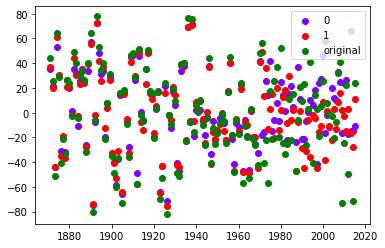

In [4]:
# For month june lag can be 0,1
# df_input is dataframe without ISMR column, used for making input feature vector
df_input = df.drop(['ISMR'],axis=1)
preds_june = np.empty((2,145))

# we run a for loop on the lag values, for june it is done separately as june can have lag values of 0,1 only
for lag in range(0,2):
    input = np.empty((145, 6))
    output_june = np.empty((145,1))
    j = 0
    
    #loading the input feature vector based on the lag value
    for i in range(1-lag, 870, 6):
        input[j][:] = df_input.iloc[i]
        j+=1

    # loading the output labels
    j = 0
    for i in range(1,870, 6):
        output_june[j][:] = df.iat[i, 1]
        j+=1
    
    # Dividing into train and test
    X_train = input[:100]
    Y_train = output_june[:100]
    X_test = input[100:]
    Y_test = output_june[100:]
    
    # Fitting the model and getting the predictions
    xg_reg.fit(X_train,Y_train)
    preds_june[lag][:] = xg_reg.predict(input)

# x is the x axis which contains the various years
x = [i for i in range(1871,2016)]
x = np.array(x)

# color contains different colors to show the scatter plots of different lag values
color = iter(cm.rainbow(np.linspace(0, 1, 2)))
for i in range(2):
    c = next(color)
    plt.scatter(x, preds_june[i], color=c, label = i)

# plot the original values in scatter plot with green color
plt.scatter(x, output_june, color = 'green', label = 'original')
plt.legend()

# print the RMSE for each lag
for lag in range(0,2):
    rmse = np.sqrt(mean_squared_error(output_june, preds_june[lag]))
    print("RMSE (for lag %d): %f" % (lag, rmse))

In [5]:
# Headers for the table
headers = ["ISMR(lag 0)", "ISMR(lag 1)", "ISMR(original)"]

total = np.empty((145,3))
total[:,:2] = preds_june.T
total[:,2:3] = output_june
# tabulate data
table = tabulate(total, headers, tablefmt="fancy_grid")

# output
print(table)

╒═══════════════╤═══════════════╤══════════════════╕
│   ISMR(lag 0) │   ISMR(lag 1) │   ISMR(original) │
╞═══════════════╪═══════════════╪══════════════════╡
│     35.4393   │     36.9212   │        44.1611   │
├───────────────┼───────────────┼──────────────────┤
│     21.6192   │     19.7943   │        25.3705   │
├───────────────┼───────────────┼──────────────────┤
│    -44.2936   │    -43.6108   │       -50.8202   │
├───────────────┼───────────────┼──────────────────┤
│     52.7661   │     61.1942   │        64.0892   │
├───────────────┼───────────────┼──────────────────┤
│     29.3915   │     30.5224   │        28.7985   │
├───────────────┼───────────────┼──────────────────┤
│    -31.1102   │    -35.105    │       -40.4921   │
├───────────────┼───────────────┼──────────────────┤
│    -19.8278   │    -18.6131   │       -21.3828   │
├───────────────┼───────────────┼──────────────────┤
│    -31.479    │    -36.8551   │       -33.3734   │
├───────────────┼───────────────┼─────────────


MONTH : July


RMSE (for lag 0): 24.759737
RMSE (for lag 1): 25.359803
RMSE (for lag 2): 25.618731

MONTH : August


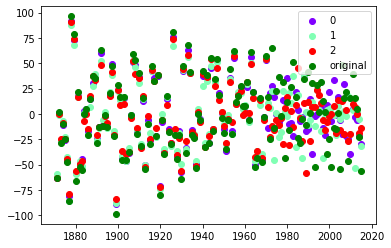

RMSE (for lag 0): 20.132870
RMSE (for lag 1): 19.755702
RMSE (for lag 2): 19.166776

MONTH : September


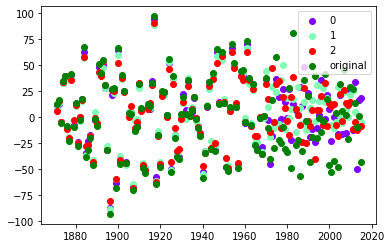

RMSE (for lag 0): 19.434242
RMSE (for lag 1): 20.430051
RMSE (for lag 2): 19.548771

MONTH : October


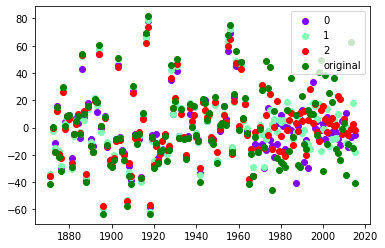

RMSE (for lag 0): 17.883832
RMSE (for lag 1): 16.622780
RMSE (for lag 2): 15.197862


<Figure size 432x288 with 0 Axes>

In [7]:
# Fitting Xgboost regressor for month July, August, September, October
months = ['July', 'August', 'September', 'October']
preds = np.empty((4,3,145))
output = np.empty((145,4))

# running a for loop for all months
for month in range(0,4):
    print("\nMONTH : %s" %(months[month]))
    
    # running a for loop for lag values between 0-2
    for lag in range(0,3):
        input = np.empty((145, 6))
        j = 0
        
        #loading the input feature vector based on the lag value and corresponding month
        for i in range(2+month-lag, 870, 6):
            input[j][:] = df_input.iloc[i]
            j+=1

        # loading the output labels of the corresponding month
        j = 0
        for i in range(2+month,870, 6):
            output[j][month] = df.iat[i, 1]
            j+=1
        
        # Divinding the data into train and test
        X_train = input[:100]
        Y_train = output[:100,month]
        X_test = input[100:]
        Y_test = output[100:,month]
        
        # Fitting the model and getting the predictions
        xg_reg.fit(X_train,Y_train)
        preds[month][lag][:] = xg_reg.predict(input)

    # x is the x axis which contains the various years
    x = [i for i in range(1871,2016)]
    x = np.array(x)
    
    # color contains different colors to show the scatter plots of different lag values
    color = iter(cm.rainbow(np.linspace(0, 1, 3)))
    for i in range(3):
        c = next(color)
        plt.scatter(x, preds[month][i], color=c, label = i)

    # plot the original values in scatter plot with green color
    plt.scatter(x, output[:,month], color = 'green', label = 'original')
    plt.legend()
    plt.show()
    
    # Clearing the plot for next month plot
    plt.clf()
    
    # print the RMSE for each lag
    for lag in range(0,3):
        rmse = np.sqrt(mean_squared_error(output[:,month], preds[month][lag]))
        print("RMSE (for lag %d): %f" % (lag, rmse))

In [8]:
for i in range(4):
    print("MONTH : %s" %(months[i]))
    
    # Headers for the table
    headers = ["ISMR(lag 0)", "ISMR(lag 1)","ISMR(lag 2)", "ISMR(original)"]

    total = np.empty((145,4))
    total[:,:3] = preds[i].T
    total[:,3] = output[:,i].T
    # tabulate data
    table = tabulate(total, headers, tablefmt="fancy_grid")

    # output
    print(table)

MONTH : July
╒═══════════════╤═══════════════╤═══════════════╤══════════════════╕
│   ISMR(lag 0) │   ISMR(lag 1) │   ISMR(lag 2) │   ISMR(original) │
╞═══════════════╪═══════════════╪═══════════════╪══════════════════╡
│     5.51199   │      4.04291  │      2.56581  │         4.76807  │
├───────────────┼───────────────┼───────────────┼──────────────────┤
│    11.0368    │     22.9602   │     18.4818   │        18.2774   │
├───────────────┼───────────────┼───────────────┼──────────────────┤
│    -5.18989   │     -4.90604  │     -3.04281  │        -8.5132   │
├───────────────┼───────────────┼───────────────┼──────────────────┤
│    31.2087    │     33.1631   │     25.3831   │        33.8961   │
├───────────────┼───────────────┼───────────────┼──────────────────┤
│    37.7225    │     32.9832   │     33.6327   │        34.9055   │
├───────────────┼───────────────┼───────────────┼──────────────────┤
│    24.403     │     21.9555   │     18.8196   │        23.8149   │
├───────────────┼────

In [9]:
# Initializing the support vector machine regression model
svr = SVR()

# List of parameters which will be tuned
parameters = [
    {"kernel":
        ["linear"],
        "C": [1, 10, 100, 1000]},
    {"kernel":
        ["poly"],
        "degree": [2, 3],
        "C": [1, 10, 100, 1000]},
    {"kernel":
        ["rbf"],
        "gamma": [1e-3, 1e-2],
        "C": [1, 10, 100, 1000]}
]

MONTH : June
LAG: 0
{'C': 1, 'degree': 2, 'kernel': 'poly'}
LAG: 1
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
RMSE (for lag 0): 33.527107
RMSE (for lag 1): 34.457063


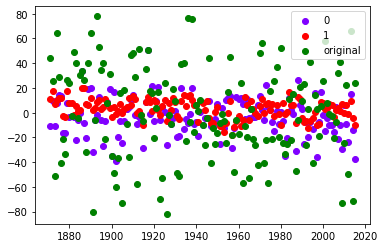

In [10]:
# For month june lag can be 0,1
preds_june = np.empty((2,145))
print("MONTH : June")

# we run a for loop on the lag values, for june it is done separately as june can have lag values of 0,1 only
for lag in range(0,2):
    input = np.empty((145, 6))
    output_june = np.empty((145,1))
    
    #loading the input feature vector based on the lag value
    j = 0
    for i in range(1-lag, 870, 6):
        # df_input is dataframe without ISMR column, used for making input feature vector
        input[j][:] = df_input.iloc[i]
        j+=1

    # loading the output labels
    j = 0
    for i in range(1,870, 6):
        output_june[j][:] = df.iat[i, 1]
        j+=1

    # Dividing into train and test
    X_train = input[:100]
    Y_train = output_june[:100]
    X_test = input[100:]
    Y_test = output_june[100:]
    
    # Doing Grid search for the best HyperParameters
    clf = GridSearchCV(svr, parameters)
    clf.fit(X_train,Y_train.ravel())
    
    # Printing the best paramters for the Lag value
    print("LAG: %d" %(lag))
    print(clf.best_params_)
    
    # Getting the predictions from the best estimator
    model = clf.best_estimator_
    preds_june[lag][:] = model.predict(input)

# x is the x axis which contains the various years
x = [i for i in range(1871,2016)]
x = np.array(x)

# color contains different colors to show the scatter plots of different lag values
color = iter(cm.rainbow(np.linspace(0, 1, 2)))
for i in range(2):
    c = next(color)
    plt.scatter(x, preds_june[i], color=c, label = i)

# plot the original values in scatter plot with green color
plt.scatter(x, output_june, color = 'green', label = 'original')
plt.legend()

# print the RMSE for each lag
for lag in range(0,2):
    rmse = np.sqrt(mean_squared_error(output_june, preds_june[lag]))
    print("RMSE (for lag %d): %f" % (lag, rmse))

In [11]:
# Headers for the table
headers = ["ISMR(lag 0)", "ISMR(lag 1)", "ISMR(original)"]

total = np.empty((145,3))
total[:,:2] = preds_june.T
total[:,2:3] = output_june
# tabulate data
table = tabulate(total, headers, tablefmt="fancy_grid")

# output
print(table)

╒═══════════════╤═══════════════╤══════════════════╕
│   ISMR(lag 0) │   ISMR(lag 1) │   ISMR(original) │
╞═══════════════╪═══════════════╪══════════════════╡
│   -10.4416    │    11.1976    │        44.1611   │
├───────────────┼───────────────┼──────────────────┤
│     9.67646   │    17.3855    │        25.3705   │
├───────────────┼───────────────┼──────────────────┤
│   -10.7553    │     7.12394   │       -50.8202   │
├───────────────┼───────────────┼──────────────────┤
│     7.49957   │    10.316     │        64.0892   │
├───────────────┼───────────────┼──────────────────┤
│    14.0673    │    11.8403    │        28.7985   │
├───────────────┼───────────────┼──────────────────┤
│    13.2141    │    12.017     │       -40.4921   │
├───────────────┼───────────────┼──────────────────┤
│   -16.2294    │    -2.36493   │       -21.3828   │
├───────────────┼───────────────┼──────────────────┤
│   -16.6086    │    -3.27404   │       -33.3734   │
├───────────────┼───────────────┼─────────────


MONTH : July
LAG: 0
{'C': 10, 'degree': 3, 'kernel': 'poly'}
LAG: 1
{'C': 1, 'degree': 2, 'kernel': 'poly'}
LAG: 2
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


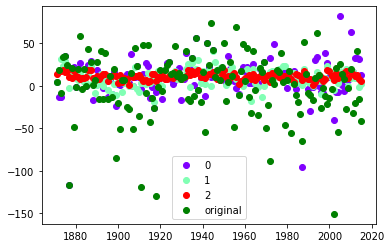

RMSE (for lag 0): 33.469492
RMSE (for lag 1): 36.408214
RMSE (for lag 2): 38.317048

MONTH : August
LAG: 0
{'C': 10, 'kernel': 'linear'}
LAG: 1
{'C': 10, 'kernel': 'linear'}
LAG: 2
{'C': 10, 'kernel': 'linear'}


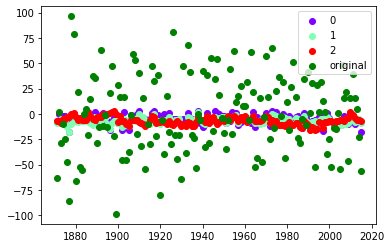

RMSE (for lag 0): 36.858811
RMSE (for lag 1): 37.748985
RMSE (for lag 2): 38.024738

MONTH : September
LAG: 0
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
LAG: 1
{'C': 100, 'kernel': 'linear'}
LAG: 2
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


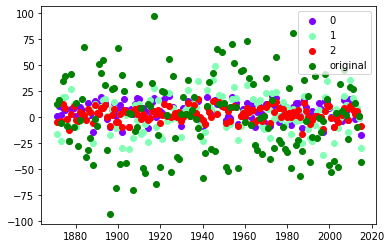

RMSE (for lag 0): 33.921301
RMSE (for lag 1): 32.093328
RMSE (for lag 2): 34.557735

MONTH : October
LAG: 0
{'C': 10, 'kernel': 'linear'}
LAG: 1
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
LAG: 2
{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


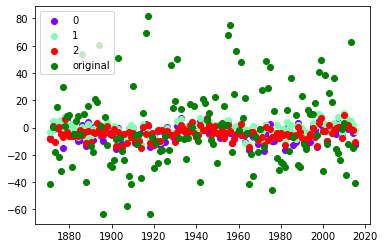

RMSE (for lag 0): 27.489819
RMSE (for lag 1): 27.734578
RMSE (for lag 2): 27.760888


<Figure size 432x288 with 0 Axes>

In [12]:
# Fitting support vector machine regression model for month July, August, September, October
months = ['July', 'August', 'September', 'October']
preds = np.empty((4,3,145))
output = np.empty((145,4))

# running a for loop for all months
for month in range(0,4):
    print("\nMONTH : %s" %(months[month]))
    
    # running a for loop for lag values between 0-2
    for lag in range(0,3):
        input = np.empty((145, 6))
        
        # loading the input feature vector based on the lag value and corresponding month
        j = 0
        for i in range(2+month-lag, 870, 6):
            # df_input is dataframe without ISMR column, used for making input feature vector
            input[j][:] = df_input.iloc[i]
            j+=1

        # loading the output labels of the corresponding month
        j = 0
        for i in range(2+month,870, 6):
            output[j][month] = df.iat[i, 1]
            j+=1

        # Dividing into train and test
        X_train = input[:100]
        Y_train = output[:100,month]
        X_test = input[100:]
        Y_test = output[100:,month]
        
        # Doing Grid search for the best HyperParameters
        clf = GridSearchCV(svr, parameters)
        clf.fit(X_train,Y_train.ravel())
        
        # Printing the best paramters for the Lag value
        print("LAG: %d" %(lag))
        print(clf.best_params_)
        
        # Getting the predictions from the best estimator
        model = clf.best_estimator_
        preds[month][lag][:] = model.predict(input)

    # x is the x axis which contains the various years
    x = [i for i in range(1871,2016)]
    x = np.array(x)
    
    # color contains different colors to show the scatter plots of different lag values
    color = iter(cm.rainbow(np.linspace(0, 1, 3)))
    for i in range(3):
        c = next(color)
        plt.scatter(x, preds[month][i], color=c, label = i)

    # plot the original values in scatter plot with green color
    plt.scatter(x, output[:,month], color = 'green', label = 'original')
    plt.legend()
    plt.show()
    
    # Clearing the plot for next month plot
    plt.clf()
    
    # print the RMSE for each lag
    for lag in range(0,3):
        rmse = np.sqrt(mean_squared_error(output[:,month], preds[month][lag]))
        print("RMSE (for lag %d): %f" % (lag, rmse))

In [13]:
for i in range(4):
    print("MONTH : %s" %(months[i]))
    
    # Headers for the table
    headers = ["ISMR(lag 0)", "ISMR(lag 1)","ISMR(lag 2)", "ISMR(original)"]

    total = np.empty((145,4))
    total[:,:3] = preds[i].T
    total[:,3] = output[:,i].T
    # tabulate data
    table = tabulate(total, headers, tablefmt="fancy_grid")

    # output
    print(table)

MONTH : July
╒════════════════╤═══════════════╤═══════════════╤══════════════════╕
│    ISMR(lag 0) │   ISMR(lag 1) │   ISMR(lag 2) │   ISMR(original) │
╞════════════════╪═══════════════╪═══════════════╪══════════════════╡
│    4.86795     │     4.86807   │     13.7151   │         4.76807  │
├────────────────┼───────────────┼───────────────┼──────────────────┤
│  -12.7632      │    18.4138    │     16.7484   │        18.2774   │
├────────────────┼───────────────┼───────────────┼──────────────────┤
│  -13.6674      │    31.6181    │     16.7489   │        -8.5132   │
├────────────────┼───────────────┼───────────────┼──────────────────┤
│   31.7755      │    22.6613    │     18.307    │        33.8961   │
├────────────────┼───────────────┼───────────────┼──────────────────┤
│   34.8058      │    28.5308    │     16.3696   │        34.9055   │
├────────────────┼───────────────┼───────────────┼──────────────────┤
│   23.7145      │    16.3922    │     17.009    │        23.8149   │
├──────